In [1]:
import numpy as np
from myplotstyle import plt, FIG_HEIGHT, FIG_WIDTH, legend_ordered

from easyquery import Query, QueryMaker
import SAGA
from SAGA import ObjectCuts as C
from SAGA import HostCuts as H

from astropy.coordinates import SkyCoord
import astropy.units as u

In [2]:
print(SAGA.__version__)
saga = SAGA.QuickStart()

3.0.0
SAGA `shared_dir` set to /home/yymao/Dropbox/Work/SAGA
SAGA `local_dir`  set to /home/yymao/Documents/Work/Data/SAGA


In [3]:
all_hosts = saga.host_catalog.load(query="good_hosts", include_stats=True)

In [4]:
has_any = H.has_image
assert (has_any | (~H.good)).mask(all_hosts).all()

In [5]:
print(
    Query(H.good, H.paper3).count(all_hosts),
    len(all_hosts),
    sep="\n",
)

101
203


In [6]:
# CONVERT RA/DEC TO RADIANS FOR PLOTTING
def convert_radec2radian(RA, Dec, origin=0):
    x = np.remainder(RA + 360 - origin, 360)  # shift RA values
    ind = x > 180
    x[ind] -= 360  # scale conversion to [-180, 180]
    x = -x  # reverse the scale: East to the left

    xrad = np.radians(x)
    yrad = np.radians(Dec)

    return xrad, yrad

In [7]:
# DEFINE GALACTIC PLANE
glat = np.arange(0, 360, 1) * u.degree + 218.0 * u.degree
glon = np.zeros(np.size(glat)) * u.degree
c = SkyCoord(l=glat, b=glon, frame="galactic")
gplane = c.transform_to("icrs")

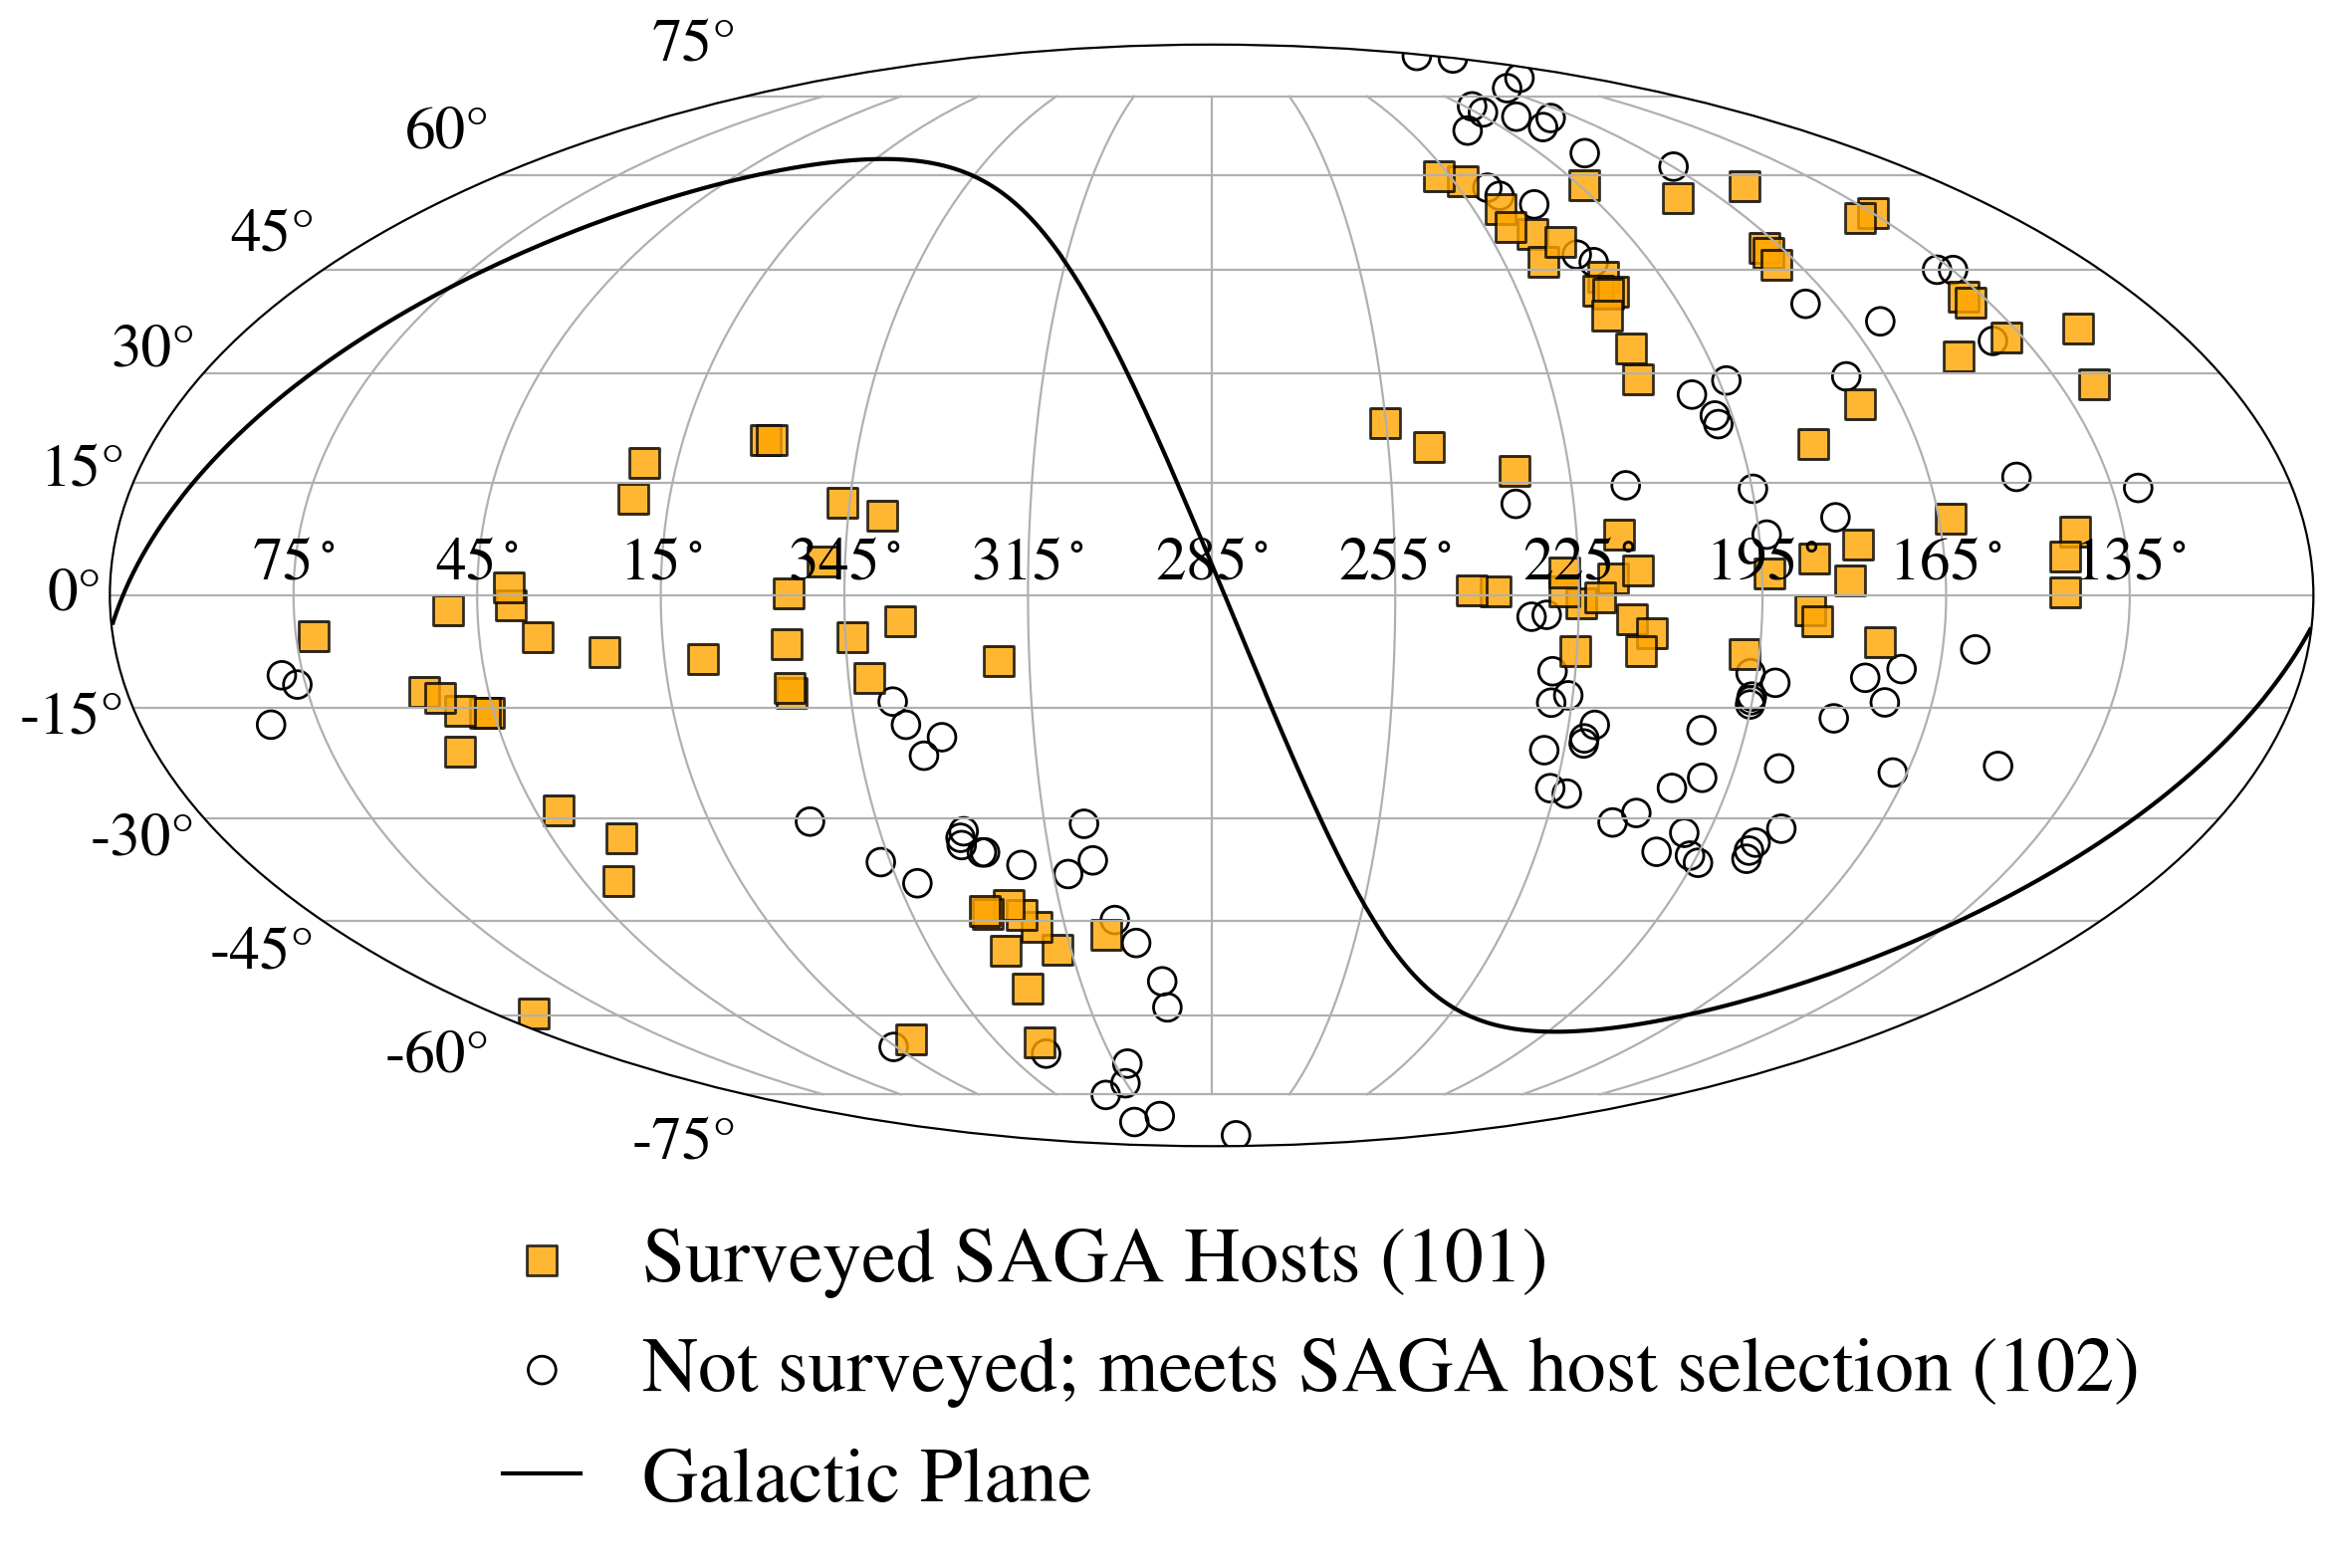

In [8]:
fig = plt.figure(figsize=(FIG_WIDTH * 2, FIG_HEIGHT * 2))
plt.rcParams["font.size"] = 22

ax = fig.add_subplot(111, projection="mollweide")  # ,projection = 'hammer')
ticks = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
origin = 285.0
ticks = np.remainder(ticks + 360 + origin, 360)
tick_labels = np.array([r"{:g}$^\circ$".format(d) for d in ticks])


def add_points(*queries, **plot_options):
    t = Query(*queries).filter(all_hosts)
    if "label" in plot_options:
        plot_options["label"] = plot_options["label"].format(len(t))
    xh, yh = convert_radec2radian(t["RA"], t["DEC"], origin=origin)
    ax.scatter(xh, yh, **plot_options)


# GOOD HOSTS W/IMAGING
add_points(
    ~H.paper3,
    s=100,
    facecolors="none",
    edgecolors="k",
    label="Not surveyed; meets SAGA host selection ({})",
)
add_points(
    H.paper3,
    s=110,
    marker="s",
    facecolors="orange",
    edgecolors="k",
    alpha=0.8,
    label="Surveyed SAGA Hosts ({})",
)

# PLOT GALAXY PLANE
xg, yg = convert_radec2radian(gplane.ra.degree, gplane.dec.degree, origin=origin)
ax.plot(xg, yg, "k", label="Galactic Plane")
ax.grid(True)

legend_ordered(ax, [1,0,2], loc="lower center", bbox_to_anchor=(0.55, -0.4), handletextpad=0.8, handlelength=1, fontsize=28)
ax.set_xticklabels(tick_labels)

plt.savefig("plots/host-footprint.pdf")

### Check footprint overlap

In [9]:
import healpy as hp

In [10]:
all_pix = set()
npix = 0
nside = 2 ** 13

for host in H.paper3.filter(all_hosts):
    center = hp.ang2vec(host["RA"], host["DEC"], lonlat=True)
    pix = hp.query_disc(nside, center, np.arcsin(0.3 / host["DIST"]))
    pix = np.setdiff1d(pix, hp.query_disc(nside, center, np.arcsin(0.01 / host["DIST"])), assume_unique=True)
    all_pix.update(pix)
    npix += len(pix)

pixarea = hp.nside2pixarea(nside, degrees=True)

print(len(all_pix) * pixarea, (npix-len(all_pix)) * pixarea)

84.70462514285897 1.0047549778547256
